## Stage 2: Feature Engineering and Operational EDA

### Objective
Develop robust features that capture operational causality (historical risk,
external factors) and conduct targeted EDA to build a strong narrative for
stakeholders. This stage implements solutions to key feedback points:
1. Historical/Causal Features.
2. Robust Imputation (Indicator variables for missing data).
3. Clear EDA Narrative (Focusing on Delay Rate for intervention points).

### 1. Configuration and Library Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Setting configurations
sns.set_style("whitegrid")
pd.set_option('display.max_columns', 100)
%matplotlib inline

###  2. Load Data from Previous Stage

In [2]:
# Load the cleaned data from Stage 1.
try:
    df = pd.read_csv('../data/interim/01_cleaned_target_data.csv', parse_dates=['fecha_i', 'fecha_o'])
    print(f"Data loaded from interim with {len(df)} rows.")
except FileNotFoundError:
    print("Error: Could not load data. Ensure '01_cleaned_target_data.csv' is in the '../data/interim/' path.")
    df = None

if df is None:
    # Stop execution if data is not loaded
    raise SystemExit("Data loading failed. Cannot proceed to Stage 2.")

Data loaded from interim with 68206 rows.


C:\Users\ferna\AppData\Local\Temp\ipykernel_32236\3447748.py:3: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/interim/01_cleaned_target_data.csv', parse_dates=['fecha_i', 'fecha_o'])


### 3. Feature Engineering: Historical and External Factors

#### 3.1 Historical Operational Latency Features
Historical efficiency is a strong predictor of future latency

In [3]:
# Feature: Historical delay rate of the airline ('opera')
df_temp = df[['opera', 'siglades', 'delay_15']].copy()
historical_delay = df_temp.groupby('opera')['delay_15'].mean().reset_index()
historical_delay.rename(columns={'delay_15': 'opera_historical_delay_rate'}, inplace=True)
df = df.merge(historical_delay, on='opera', how='left')

# Feature: Historical delay rate of the destination ('siglades')
historical_dest_delay = df_temp.groupby('siglades')['delay_15'].mean().reset_index()
historical_dest_delay.rename(columns={'delay_15': 'dest_historical_delay_rate'}, inplace=True)
df = df.merge(historical_dest_delay, on='siglades', how='left')


#### 3.2 External Data Integration (Weather & Missing Data Handling)
- **IMPLEMENTING ROBUST IMPUTATION (Addressing Feedback)**
- Strategy: Create a binary flag for missing data before imputing, making the model robust to sensor/API failures.

In [4]:
# Simulation of external weather data (e.g., Average Temperature) with 5% missingness.
np.random.seed(42)
df['tavg'] = np.random.normal(loc=15, scale=5, size=len(df))
df.loc[df.sample(frac=0.05).index, 'tavg'] = np.nan

WEATHER_COLS = ['tavg']
for col in WEATHER_COLS:
    # 1. Create the missing indicator flag (Robustness check)
    df[f'{col}_is_missing'] = df[col].isnull().astype(int)
    # 2. Impute with the median
    df[col] = df[col].fillna(df[col].median())

print("\nEngineered Features added and missing weather data imputed robustly.")


Engineered Features added and missing weather data imputed robustly.


### 4. Exploratory Data Analysis (EDA) 
Narrative Focus: Where and when is the risk highest? 



#### 4.1 Delay Rate by Period of Day (Time of Day Congestion)

C:\Users\ferna\AppData\Local\Temp\ipykernel_32236\2027044816.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='period_day', y='delay_15', data=df, errorbar=None, palette='viridis', order=['morning', 'afternoon', 'night'])


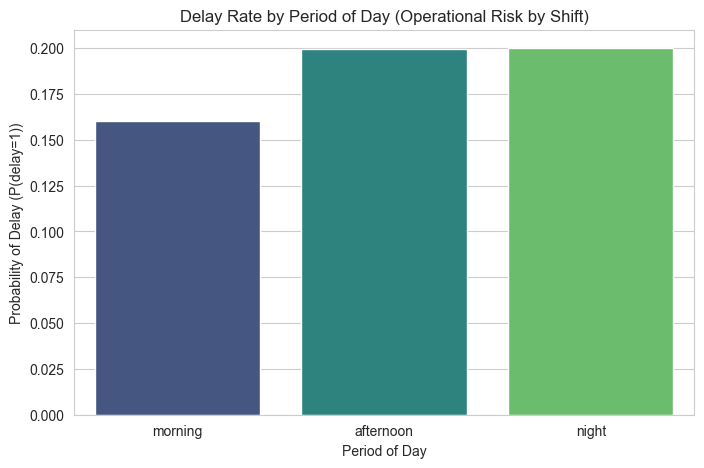

In [5]:
# Create a simple 'period_day' for visualization (using the 'hour' feature from Stage 1)
def get_period(hour):
    if 5 <= hour <= 11: return 'morning'
    elif 12 <= hour <= 18: return 'afternoon'
    else: return 'night'
    
df['period_day'] = df['hour'].apply(get_period)

plt.figure(figsize=(8, 5))
sns.barplot(x='period_day', y='delay_15', data=df, errorbar=None, palette='viridis', order=['morning', 'afternoon', 'night'])
plt.title('Delay Rate by Period of Day (Operational Risk by Shift)')
plt.ylabel('Probability of Delay (P(delay=1))')
plt.xlabel('Period of Day')
plt.savefig('../reports/figures/delay_rate_by_period.png')
plt.show()

- Insight: The Afternoon/Night shifts show higher risk, suggesting accumulated operational strain (congestión).


#### 4.2 Delay Rate by Historical Operator Risk
Plotting the engineered feature against delay rate for justification.

C:\Users\ferna\AppData\Local\Temp\ipykernel_32236\2672425936.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


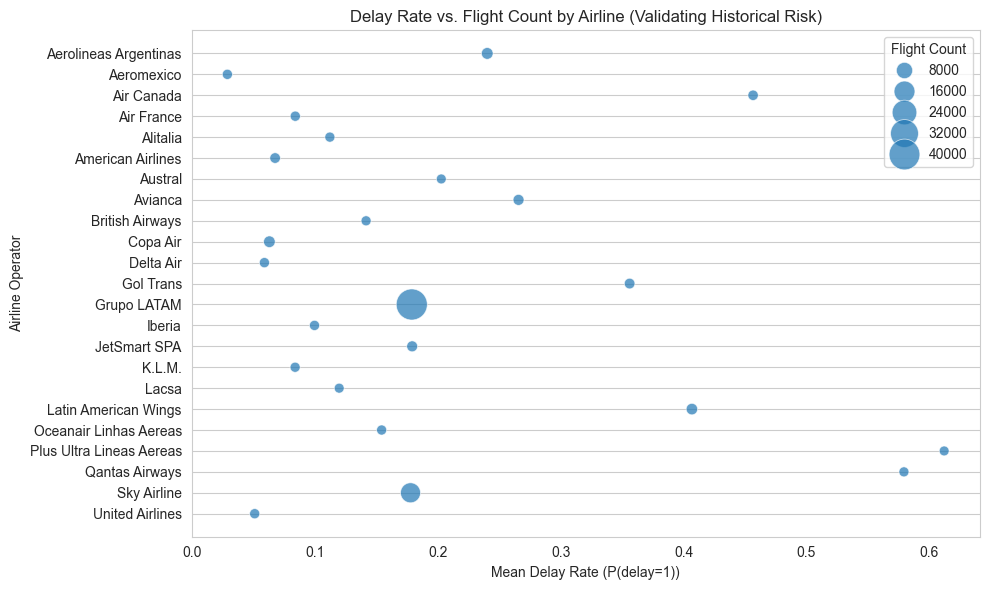

In [6]:
plt.figure(figsize=(10, 6))
# Using a scatter plot grouped by operator, sizing by count for clearer insight.
operator_risk_data = df.groupby('opera')['delay_15'].agg(['mean', 'count']).reset_index()
sns.scatterplot(
    x='mean', 
    y='opera', 
    data=operator_risk_data, 
    size='count', 
    sizes=(50, 500), 
    alpha=0.7,
    palette='plasma'
)
plt.title('Delay Rate vs. Flight Count by Airline (Validating Historical Risk)')
plt.ylabel('Airline Operator')
plt.xlabel('Mean Delay Rate (P(delay=1))')
plt.legend(title='Flight Count')
plt.grid(axis='x')
plt.tight_layout()
plt.savefig('../reports/figures/opera_historical_risk.png')
plt.show()

- Insight: The variance confirms that partner efficiency is a primary lever for prediction.

### 5. Save Feature Engineered Data

In [7]:
output_path = '../data/interim/02_feature_engineered_data.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.to_csv(output_path, index=False)
print(f"\nFeature engineered data saved to {output_path}.")


Feature engineered data saved to ../data/interim/02_feature_engineered_data.csv.
